In [1]:
import numpy as np
from pathlib import Path
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from tqdm import tqdm
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torch.autograd import Variable
from preprocessing import *
from model import *
import time
import wandb 

In [2]:
class Average(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def find_latest_model(dir):
    model_paths, epochs = [], []
    for path in Path(dir).glob('*.pt'):
        if 'epoch' not in path.stem:
            continue
        model_paths.append(path)
        parts = path.stem.split('_')
        epochs.append(int(parts[-1]))

    if len(epochs) > 0:
        epochs = np.array(epochs)
        max_idx = np.argmax(epochs)
        return model_paths[max_idx]
    else:
        return None

In [3]:
class MetricsMethod(object):
    def __init__(self, prob_pred_masks: Tensor, true_masks: Tensor, num_class: int, smooth: float=1e-7) -> None:
        self.prob_pred_masks = prob_pred_masks
        self.true_masks = true_masks
        y_pred = torch.argmax(prob_pred_masks, dim=1)
        y_true = true_masks
        assert y_pred.size() == y_true.size(), "Input size and target size is not matching"

        self.matrix = self.confusion_matrix(y_pred, y_true)
        self.num_class = num_class
        self.smooth = smooth

    def PA(self):
        return torch.diagonal(self.matrix,0).sum() / self.matrix.sum()

    def CPA(self):
        cpa_list = list()
        for idx in range(self.num_class):
            cpa_list.append((self.matrix[idx,idx] + self.smooth)/ \
                            (self.matrix[:,idx].sum() + self.smooth))
        return np.array(cpa_list)

    def MPA(self):
        return self.CPA().sum() / self.num_class

    def Dice(self):
        pass

    def IoU(self):
        iou_list = list()
        for idx in range(self.num_class):
            iou_list.append((self.matrix[idx,idx] + self.smooth)/ \
                            (self.matrix[:,idx].sum() + self.matrix[idx,:].sum() \
                            - self.matrix[idx,idx] + self.smooth))
        return np.array(iou_list)

    def MIoU(self):
        return self.IoU().sum() / self.num_class

    def BinIoU(self, pred_masks, true_masks):
        pred_masks, true_masks = pred_masks.flatten(), true_masks.flatten()
        inter = (pred_masks * true_masks).sum()
        union = ((pred_masks + true_masks) > 0).sum()
        return inter / union

    def mAP(self, thres: list=[0.5]):
        input = self.prob_pred_masks
        input = input.numpy()
        one_hot_true_masks = F.one_hot(self.true_masks.squeeze(1), 8).permute(0, 3, 1, 2).numpy()
        sum_PA = 0
        mPA = 0
        for d in range(input.shape[1]):
            t_input = np.zeros(input.shape)
            for t in thres:
                t_input[input >= t] = 1
                sum_PA += self.BinIoU(t_input[:,d,:,:], one_hot_true_masks[:,d,:,:])
            mPA += (sum_PA / len(thres))
        return mPA / self.num_class
        
    def confusion_matrix(self, y_pred, y_true):
        N = max(max(y_true), max(y_pred)) + 1
        y_true = torch.tensor(y_true, dtype=torch.long)
        y_pred = torch.tensor(y_pred, dtype=torch.long)
        return torch.sparse.LongTensor(
            torch.stack([y_true, y_pred]), 
            torch.ones_like(y_true, dtype=torch.long),
            torch.Size([N, N])).to_dense().numpy()

In [4]:
class DiceLoss(object):
    def __init__(self, multiclass: bool = False, reduce_batch_first=True) -> None:
        self.fn = self.multiclass_dice_coeff if multiclass else self.dice_coeff
        self.reduce_batch_first = reduce_batch_first

    def loss(self, input: Tensor, target: Tensor) -> Tensor:
        return 1 - self.fn(input, target, reduce_batch_first=self.reduce_batch_first)

    def dice_coeff(self, input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
        # Average of Dice coefficient for all batches, or for a single mask
        assert input.size() == target.size()
        assert input.dim() == 3 or not reduce_batch_first

        sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

        inter = 2 * (input * target).sum(dim=sum_dim)
        sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
        print(f"{inter=}")
        print(f"{sets_sum=}")
        sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
        print(f"{sets_sum=}\n")

        dice = (inter + epsilon) / (sets_sum + epsilon)
        return dice.mean()

    def multiclass_dice_coeff(self, input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
        # Average of Dice coefficient for all classes
        return self.dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

In [5]:
def plot_training_loss(model_dir: str, target_dir: str, title: str):
    paths = [path for path in Path(model_dir).glob('*.pt')]
    paths = sorted(paths)
    epochs = []
    tr_losses = []
    vl_losses = []
    for path in tqdm(paths):
        if 'epoch' not in path.stem:
            continue
        parts = path.stem.split('_')
        epoch = int(parts[-1])
        epochs.append(epoch)
        state = torch.load(path)
        val_los = state['valid_loss']
        train_loss = float(state['train_loss'])
        tr_losses.append(train_loss)
        vl_losses.append(val_los)

    sorted_idxs = np.argsort(epochs)
    tr_losses = [tr_losses[idx] for idx in sorted_idxs]
    vl_losses = [vl_losses[idx] for idx in sorted_idxs]

    data = {}
    data['tr_losses']=tr_losses
    data['vl_losses']=vl_losses
    with open(os.path.join(target_dir, 'training_loss.json'), 'w', newline='') as jsonfile:
        json.dump(data, jsonfile)

    plt.plot(tr_losses[1:], label='train_loss')
    plt.plot(vl_losses[1:], label='valid_loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(target_dir, 'training_loss.jpg'), dpi=500)
    plt.show()

In [6]:
def GraphVisualization(dataset: MyDataset, model=None, col=5, target_dir: str="./"):
    rows = ['Images', 'Ground\nTruth\nMasks', 'Ground\nTruth\nFusions',
            'Prediction\nMasks', 'Prediction\nFusions', 'Prediction V.S.\nGround Truth']
    if model is None:
        fig, axes = plt.subplots(nrows=3, ncols=col, figsize=(10,10))
        fig.patch.set_facecolor('white')

        for i in range(3):
            axes[i][0].annotate(rows[i], xy=(0, 0.5), xytext=(-30,60),
                                xycoords='axes points', textcoords='offset points',
                                size='large', ha='center', va='center')

        for i in range(col):
            filename = Path(dataset.imgPaths[i]).stem
            data = dataset.__getitem__(i)
            mask = np.array(data[1]).squeeze()
            invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                                 std = [ 1., 1., 1. ])])
            img = invTrans(data[0])
            img = np.array(img).transpose(1,2,0)

            axes[0][i].set_title(filename, {'fontsize': 8})
            axes[0][i].get_xaxis().set_visible(False)
            axes[0][i].get_yaxis().set_visible(False)
            axes[0][i].imshow(img)
            axes[1][i].get_xaxis().set_visible(False)
            axes[1][i].get_yaxis().set_visible(False)
            axes[1][i].imshow(mask, cmap='magma')
            axes[2][i].get_xaxis().set_visible(False)
            axes[2][i].get_yaxis().set_visible(False)
            axes[2][i].imshow(img)
            axes[2][i].imshow(mask, cmap='twilight', alpha=0.6)

        fig.tight_layout(h_pad=-25)
        plt.savefig(os.path.join(target_dir, 'sample.png'), dpi=500)
        plt.show()
    else:
        fig, axes = plt.subplots(nrows=5, ncols=col, figsize=(10,10))
        fig.patch.set_facecolor('white')

        for i in range(5):
            axes[i][0].annotate(rows[i], xy=(0, 0.5), xytext=(-45,45),
                                xycoords='axes points', textcoords='offset points',
                                size='large', ha='center', va='center')

        for i in range(col):
            filename = Path(dataset.imgPaths[i]).stem
            data = dataset.__getitem__(i)
            mask = np.array(data[1]).squeeze()
            invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                                 std = [ 1., 1., 1. ])])
            img = invTrans(data[0])
            img = np.array(img).transpose(1,2,0)
            
            model.eval()
            with torch.no_grad():
                input_img  = Variable(torch.unsqueeze(data[0], 0)).to(device, dtype=torch.float32)
                masks_true = Variable(torch.unsqueeze(data[1], 0)).to(device, dtype=torch.long)
                masks_pred = model(input_img)
                pred_mask = torch.argmax(masks_pred, dim=1).squeeze(0).cpu()

            axes[0][i].set_title(filename, {'fontsize': 8})
            axes[0][i].get_xaxis().set_visible(False)
            axes[0][i].get_yaxis().set_visible(False)
            axes[0][i].imshow(img)
            axes[1][i].get_xaxis().set_visible(False)
            axes[1][i].get_yaxis().set_visible(False)
            axes[1][i].imshow(mask, cmap='magma')
            axes[2][i].get_xaxis().set_visible(False)
            axes[2][i].get_yaxis().set_visible(False)
            axes[2][i].imshow(img)
            axes[2][i].imshow(mask, cmap='twilight', alpha=0.6)

            axes[3][i].get_xaxis().set_visible(False)
            axes[3][i].get_yaxis().set_visible(False)
            axes[3][i].imshow(pred_mask, cmap='magma')
            axes[4][i].get_xaxis().set_visible(False)
            axes[4][i].get_yaxis().set_visible(False)
            axes[4][i].imshow(img)
            axes[4][i].imshow(pred_mask, cmap='twilight', alpha=0.6)
#             axes[5][i].get_xaxis().set_visible(False)
#             axes[5][i].get_yaxis().set_visible(False)
#             axes[5][i].imshow(pred_mask, cmap='magma')
#             axes[2][i].imshow(mask, cmap='twilight', alpha=0.6)

        fig.tight_layout(h_pad=1)
        plt.savefig(os.path.join(target_dir, 'sample_pred.png'), dpi=500)
        plt.show()

In [7]:
def evaluate(model, test_loader, criterion, model_dir):
    method = {'pa': list(),
             'cpa': list(),
             'mpa': list(),
             'iou': list(),
             'miou': list(),
             'map': list()}

    best_model_path = os.path.join(*[model_dir, 'model_best.pt'])
    state = torch.load(best_model_path)
    model.load_state_dict(state['model'])
    
    model.eval()
    with torch.no_grad():

        for i, (input_img, masks_true) in enumerate(test_loader):
            input_img  = Variable(input_img).to(device, dtype=torch.float32)
            masks_true = Variable(masks_true).to(device, dtype=torch.long)

            masks_pred = model(input_img)
            metrics = MetricsMethod(masks_pred.cpu(), masks_true, 8)
            method['pa'].append(metrics.PA)
            method['cpa'].append(metrics.CPA)
            method['mpa'].append(metrics.MPA)
            method['iou'].append(metrics.IoU)
            method['miou'].append(metrics.MIoU)
            method['map'].append(metrics.mAP)
    
    print('mAP@[.5:.95:.05]:', method['map'].sum()/len(test_loader*config['batch_size']), 
          ' PA:', method['pa'].sum()/len(test_loader*config['batch_size']), 
          ' MPA:', method['mpa'].sum()/len(test_loader*config['batch_size']), 
          ' mIoU:', method['miou'].sum()/len(test_loader*config['batch_size']))        

    return losses.avg

In [8]:
def validate(model, val_loader, criterion):
    losses = Average()
    model.eval()
    with torch.no_grad():

        for i, (input_img, masks_true) in enumerate(val_loader):
            input_img  = Variable(input_img).to(device, dtype=torch.float32)
            masks_true = Variable(masks_true).to(device, dtype=torch.long)

            masks_pred = model(input_img)
            
            masks_true = F.one_hot(masks_true.squeeze(1), 8).permute(0, 3, 1, 2).float().to(f'cuda:{unet.device_ids[0]}')
            loss = criterion(masks_pred, masks_true)

            losses.update(loss.item(), masks_true.size(0))

    return losses.avg

In [9]:
def train(config, train_loader, model, criterion, optimizer, scheduler, validation):
    wandb.watch(model, criterion=criterion, log="all", log_freq=10)

    latest_model_path = find_latest_model(model_dir)
    best_model_path = os.path.join(*[model_dir, 'model_best.pt'])

    if latest_model_path is not None:
        state = torch.load(latest_model_path)
        epoch = state['epoch']
        model.load_state_dict(state['model'])
        epoch = epoch

        assert Path(best_model_path).exists() == True, f'best model path {best_model_path} does not exist'
        best_state = torch.load(latest_model_path)
        min_val_los = best_state['valid_loss']

        print(f'Restored model at epoch {epoch}. Min validation loss : {min_val_los}')
        epoch += 1
        print(f'Started training model from epoch {epoch}')
    else:
        print('Started training model from epoch 0')
        epoch = 0
        min_val_los = 9999

    valid_losses = []
    start_time = time.time()
    for epoch in range(epoch, config['n_epoch'] + 1):

        tq = tqdm(total=(len(train_loader) * config['batch_size']))
        tq.set_description(f'Epoch {epoch}')

        running_losses = Average()

        model.train()
        for i, (input_img, masks_true) in enumerate(train_loader):
            input_img  = Variable(input_img, requires_grad=True).to(device, dtype=torch.float32)
            masks_true = Variable(masks_true, requires_grad=True).to(device, dtype=torch.long)

            masks_pred = model(input_img)
            output = masks_pred
            
            masks_true = F.one_hot(masks_true.squeeze(1), 8).permute(0, 3, 1, 2).float().to(f'cuda:{unet.device_ids[0]}')
            loss = criterion(masks_pred, masks_true)
            running_loss = loss
            running_losses.update(running_loss.cpu().item(), masks_true.size(0))

            tq.set_postfix(loss='{:.5f}'.format(running_losses.avg))
            tq.update(config['batch_size'])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        valid_loss = validation(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        print(f'valid_loss = {valid_loss:.5f}')
        tq.close()
        
        wandb.log({"training_loss": running_losses.avg})
        wandb.log({"valid_loss": valid_loss})
        
        epoch_model_path = os.path.join(*[model_dir, f'model_epoch_{epoch}.pt'])
        torch.save({
            'model': model.state_dict(),
            'epoch': epoch,
            'valid_loss': valid_loss,
            'train_loss': running_losses.avg
        }, epoch_model_path)

        if valid_loss < min_val_los:
            min_val_los = valid_loss
            torch.save({
                'model': model.state_dict(),
                'epoch': epoch,
                'valid_loss': valid_loss,
                'train_loss': running_losses.avg
            }, best_model_path)
    
    finished_training_time = (time.time()-start_time)
    print(f"training_time(s): ", finished_training_time)
    wandb.log({"training_time(s)": finished_training_time})

In [10]:
config = dict(
    n_epoch         = 20,
    batch_size      = 16,
    lr              = 0.001,
    num_workers     = 12,
    momentum        = 0.9,
    weight_decay    = 1e-4,
    dataset         = "CCAgT",
    model           = "ResUNet",
    optimizer       = "Adam",
    scheduler       = "StepLR"
)

wandb_init = dict(
#     job_type: Optional[str] = None,
#     dir = None,
    config = config,
    project = "ResUNet with CCAgT dataset",
#     entity = None,
#     reinit = None,
    tags = ['5v1'],
#     group = None,
    name = None,
    notes = None,
#     magic = None,
#     config_exclude_keys = None,
#     config_include_keys = None,
#     anonymous = None,
    mode = "disabled",  # "online","offline","disabled"
#     allow_val_change = None,
#     resume = None,
#     force = None,
#     tensorboard = None,
#     sync_tensorboard = None,
#     monitor_gym = None,
    save_code = True,
#     settings=None
)

model_dir = "./model"
orig_img_dir = "./dataset/images"
orig_msk_dir = "./dataset/masks"
save_json = "./dataset/dataset.json"
save_samples = "./dataset/samples"

if save_samples != '':
    os.makedirs(save_samples, exist_ok=True)
    for sample in Path(save_samples).glob('*.jpg'):
        os.remove(str(sample))

if not os.path.exists(save_json):
    obtain_path(img_dir=orig_img_dir, mask_dir=orig_msk_dir, target_path=str(save_json))

os.makedirs(model_dir, exist_ok=True)

In [11]:
gpu_id = 0

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(gpu_id)
# device = torch.device("cuda:{}".format(str(gpu_id)) if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 Tesla V100-PCIE-32GB


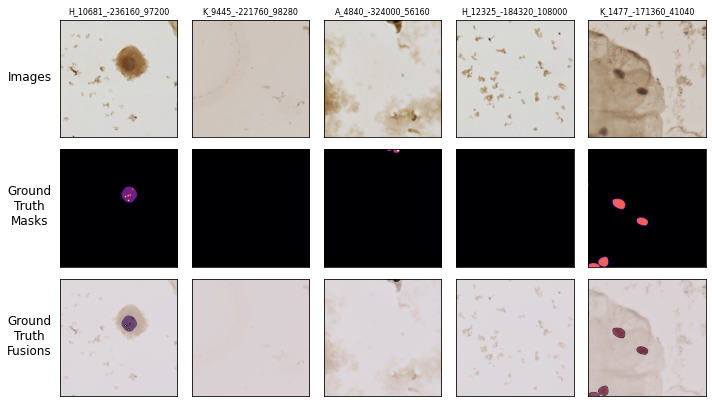

In [12]:
channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]

dataset = divide_dataset(save_json, [0.7,0.1,0.2])

train_tsfm = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(channel_means, channel_stds),
                                transforms.RandomCrop((832, 832)), 
                                transforms.RandomRotation(90), 
                                transforms.RandomHorizontalFlip()])
val_tsfm = transforms.Compose([ transforms.ToTensor(), 
                                transforms.Normalize(channel_means, channel_stds),
                                transforms.RandomCrop((832, 832))])
test_tsfm = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(channel_means, channel_stds),
                                transforms.RandomCrop((832, 832))])
train_mask_tsfm = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop((832, 832)),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip()])
mask_tsfm = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop((832, 832))])

train_set = MyDataset(dataset, train_tsfm, train_mask_tsfm, 'train')
valid_set = MyDataset(dataset, val_tsfm, mask_tsfm, 'valid')
test_set = MyDataset(dataset, test_tsfm, mask_tsfm, 'test')

train_loader = DataLoader(  train_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=True,
                            num_workers=config['num_workers'])
valid_loader = DataLoader(  valid_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=True,
                            num_workers=config['num_workers'])
test_loader = DataLoader(   test_set,
                            config['batch_size'],
                            shuffle=True,
                            pin_memory=True,
                            num_workers=config['num_workers'])

GraphVisualization(test_set, model=None, col=5, target_dir=save_samples)

In [13]:
wandb.login()
os.environ["WANDB_API_KEY"] = "x"*40
os.environ['WANDB_NOTEBOOK_NAME'] = 'main.ipynb'

wandb: Currently logged in as: ohmygoose0410. Use `wandb login --relogin` to force relogin


In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 0, 2, 3"

model = ResUNet(Block=ResBlock, DecBlock=DecBlock)
unet = torch.nn.DataParallel(model, device_ids=[1,0,2,3])
unet.to(f'cuda:{unet.device_ids[0]}')

optimizer = torch.optim.Adam(unet.parameters(), config['lr'],
                             weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, 0.1)
criterion = BCEWithLogitsLoss()

run = wandb.init(**wandb_init)

train(config, train_loader, unet, criterion, optimizer, scheduler, validate)

run.finish()

# evaluate(unet.to(f'cuda:{unet.device_ids[0]}'), test_loader, criterion, model_dir)

Restored model at epoch 21. Min validation loss : 0.0002827840795880733
Started training model from epoch 22
training_time(s):  3.337860107421875e-06


100%|██████████| 23/23 [00:02<00:00, 10.42it/s]


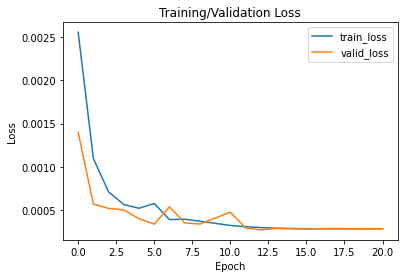

In [15]:
plot_training_loss(model_dir=model_dir, target_dir=save_samples, title='Training/Validation Loss')

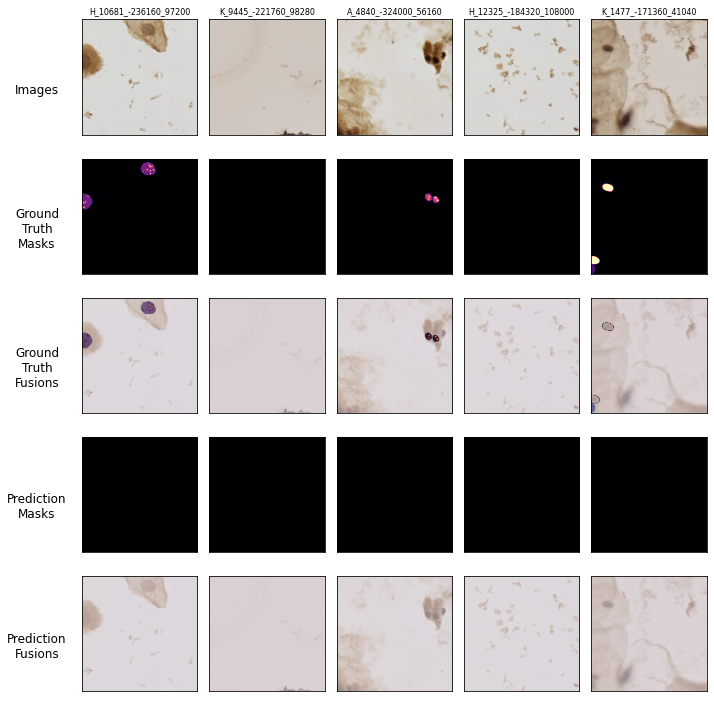

In [16]:
best_model_path = os.path.join(*[model_dir, 'model_best.pt'])
state = torch.load(best_model_path)
unet.to(f'cuda:{unet.device_ids[0]}')
unet.load_state_dict(state['model'])

GraphVisualization(test_set, model=unet, col=5, target_dir=save_samples)